# setup

In [2]:

import re
import os
import math
import pickle
import random
import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from transformers import BertForMaskedLM
from torch.utils.data import random_split
from dataloaders import random_collapse_per_path, PartialMergingTaxonomyDataset
from dataloaders import dataset_to_hf_dataset, TaxonomyPreCollator, create_taxonomy_data_collator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from scipy.spatial.distance import cdist


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Adjust these paths as needed
taxonomy_matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-taxonomy-matrix.npz"
taxonomy_mapping_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/taxonomy_mapping.csv"

# Load the sparse (samples x taxonomies) matrix
X_taxonomy = sp.load_npz(taxonomy_matrix_path)
print("X_taxonomy shape:", X_taxonomy.shape)

# Load the mapping of columns -> taxonomy strings
df_tax_mapping = pd.read_csv(taxonomy_mapping_path)
taxonomy_list = df_tax_mapping["taxonomy"].tolist()

# print("Number of taxonomies:", len(taxonomy_list))
# print("First 5 taxonomies:", taxonomy_list[:5])


## dataloader
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl"
with open(output_path, "rb") as f:
    token_dict = pickle.load(f)
print("Loaded token dictionary with size:", len(token_dict))
do_augmentation=False
# Use your dynamic PyTorch dataset directly
partial_dataset = PartialMergingTaxonomyDataset(
    X_taxonomy=X_taxonomy,
    taxonomy_list=taxonomy_list,
    token_dict=token_dict,
    max_taxa=104,
    possible_ranks=('p','c','o','f','g','s'),
    do_augmentation=do_augmentation  # dynamic augmentation enabled
)

# Assume partial_dataset is your instance of PartialMergingTaxonomyDataset
total_samples = len(partial_dataset)
val_size = int(0.2 * total_samples)
train_size = total_samples - val_size


g = torch.Generator().manual_seed(123)
train_dataset, val_dataset = random_split(partial_dataset, [train_size, val_size], generator=g)

print(f"Total samples: {total_samples}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


X_taxonomy shape: (1836255, 8533)
Loaded token dictionary with size: 11318
Total samples: 1836255
Train samples: 1469004
Validation samples: 367251


# Reference tree distances

In [7]:
def taxonomy_distance(tax1, tax2):
    ranks1 = tax1.split(";")
    ranks2 = tax2.split(";")
    prefix_len = 0
    for a, b in zip(ranks1, ranks2):
        if a == b:
            prefix_len += 1
        else:
            break
    # Distance = (# of ranks in tax1 after prefix) + (# of ranks in tax2 after prefix)
    return (len(ranks1) - prefix_len) + (len(ranks2) - prefix_len)

output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/taxonomy_token_dictionary.pkl"
with open(output_path, "rb") as f:
    token_dict = pickle.load(f)

# Get the list of taxonomies from the dictionary
taxonomies = list(token_dict.keys())
num_taxa = len(taxonomies)

# Initialize a distance matrix
dist_matrix = np.zeros((num_taxa, num_taxa))

# Compute pairwise distances
for i in range(num_taxa):
    for j in range(i + 1, num_taxa):
        dist = taxonomy_distance(taxonomies[i], taxonomies[j])
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist  # Symmetry

# Now dist_matrix[i, j] holds the distance between taxonomies[i] and taxonomies[j].
# You can save it to disk if needed:
# np.save("taxonomy_dist_matrix.npy", dist_matrix)

print("Distance matrix shape:", dist_matrix.shape)
print("Example distance [0,1]:", dist_matrix[0,1])

Distance matrix shape: (11318, 11318)
Example distance [0,1]: 2.0


In [23]:
count_no_domain = 0
no_domain_keys = []

for taxon_str in token_dict.keys():
    if not taxon_str.startswith("d__"):
        count_no_domain += 1
        no_domain_keys.append(taxon_str)

print("Number of taxonomies missing domain prefix (d__):", count_no_domain)
print("Example keys without d__ prefix:", no_domain_keys[:10])  

Number of taxonomies missing domain prefix (d__): 42
Example keys without d__ prefix: ['<pad>', '<mask>', '<cls>', '<eos>', 'c__Gammaproteobacteria', 'c__Gammaproteobacteria;o__Enterobacterales', 'c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae', 'c__Verrucomicrobiae', 'c__Verrucomicrobiae;o__Verrucomicrobiales', 'c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae']


In [ ]:
position = 0
for i in idx:
	position += 1
	print(taxonomies[i],position)

d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanocaldococcaceae;g__Methanocaldococcus_A 1
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanocaldococcaceae;g__Methanocaldococcus_A;s__Methanocaldococcus_A 2
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanocaldococcaceae;g__Methanocaldococcus;s__Methanocaldococcus 3
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanocaldococcaceae 4
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanocaldococcaceae;g__Methanocaldococcus 5
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanococcaceae;g__Methanotorris 6
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanococcaceae;g__Methanotorris;s__Methanotorris 7
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanococcaceae;g__Methanothermococcus_A 8
d__Archaea;p__Euryarchaeota;c__Methanococci;o__Methanococcales;f__Methanococcacea

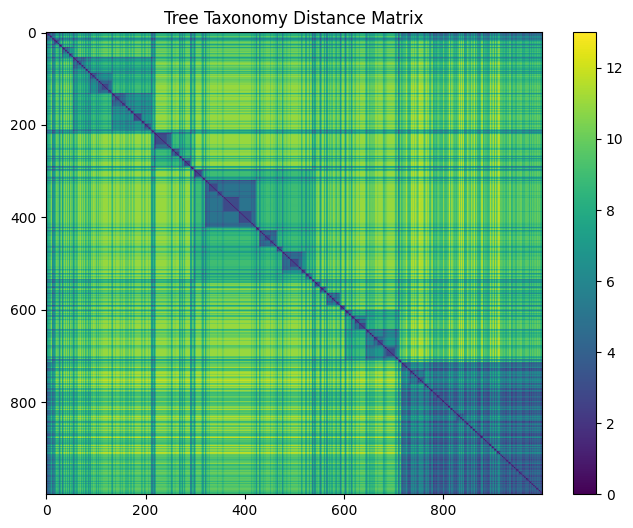

In [8]:

# Suppose 'dist_matrix' is your full NxN matrix
# For demonstration, let's just consider a subset
subset_size = 1000
subset_dist_matrix = dist_matrix[:subset_size, :subset_size]

plt.figure(figsize=(8, 6))
plt.imshow(subset_dist_matrix, aspect='auto')
plt.colorbar()
plt.title("Tree Taxonomy Distance Matrix")
plt.show()


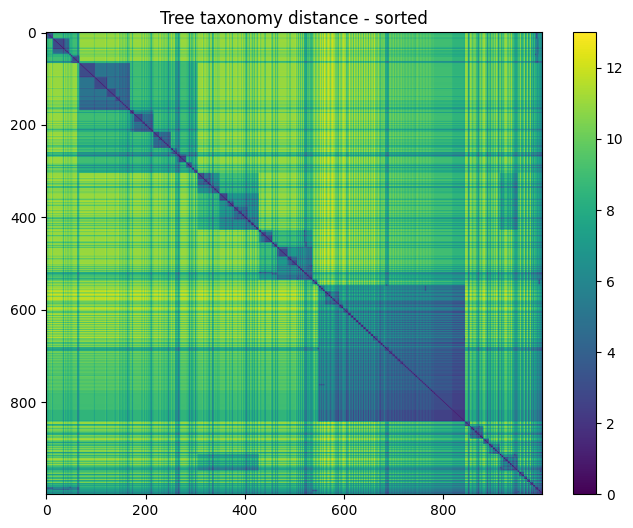

In [9]:
from scipy.cluster.hierarchy import linkage, leaves_list

# Flatten the lower triangle or pass a condensed distance matrix to linkage
# (scipy expects condensed distances: a 1D array of the upper/lower triangle)
from scipy.spatial.distance import squareform
subset_condensed = squareform(subset_dist_matrix, checks=False)

Z = linkage(subset_condensed, method='average')
# Get the order of leaves in the dendrogram
idx = leaves_list(Z)

# Reorder the matrix
reordered = subset_dist_matrix[idx, :][:, idx]

plt.figure(figsize=(8, 6))
# line_positions = [546, 842]

# for pos in line_positions:
#     plt.axhline(pos, color='red', linestyle='--', linewidth=1)
#     plt.axvline(pos, color='red', linestyle='--', linewidth=1)

# plt.axhline(689-1, color='black', linestyle='--', linewidth=1)    
# plt.axvline(689-1, color='black', linestyle='--', linewidth=1)

plt.imshow(reordered, aspect='auto')
plt.colorbar()
plt.title("Tree taxonomy distance - sorted")
plt.show()


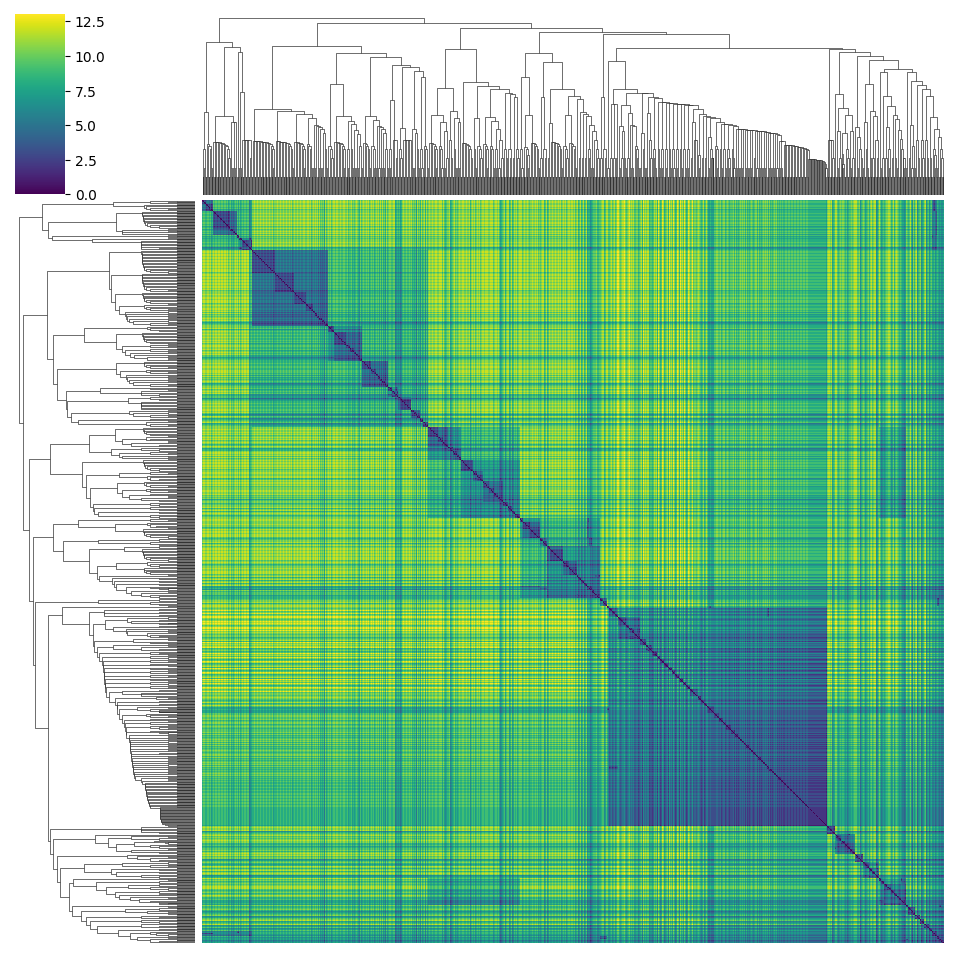

In [10]:
import seaborn as sns

subset_condensed = squareform(subset_dist_matrix, checks=False)
Z = linkage(subset_condensed, method='average')

# If you want both rows and columns to use the SAME linkage (typical if NxN is symmetrical):
row_linkage = Z
col_linkage = Z

# ----------------------------------------------------------------------------
# C) Use Seaborn’s clustermap
# ----------------------------------------------------------------------------
# Convert your distance matrix to a DataFrame
df = pd.DataFrame(subset_dist_matrix)

g = sns.clustermap(
    df,
    metric="precomputed",
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    cmap="viridis",
    figsize=(10,10),
)
# Optionally remove row/column labels for the heatmap itself:
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
plt.show()

# Model embeddings distances

In [11]:
from transformers import BertForMaskedLM


Embedding matrix shape: (11318, 256)
Embedding distance matrix shape: (1000, 1000)


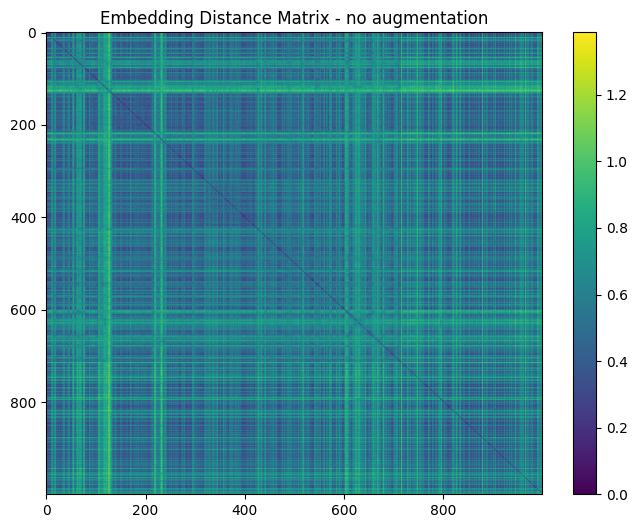

In [70]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
epoch_to_test = 50  
sample_index = 10   


checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()
embedding_layer = model.bert.embeddings.word_embeddings
# This is a nn.Embedding, whose "weight" is a matrix of size [vocab_size, hidden_dim]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()
print("Embedding matrix shape:", embedding_weights.shape)


dist_matrix_embedding = cdist(embedding_weights[0:1000,:], embedding_weights[0:1000,:], metric='cosine')
print("Embedding distance matrix shape:", dist_matrix_embedding.shape)


reordered = dist_matrix_embedding#[idx, :][:, idx]


plt.figure(figsize=(8, 6))
line_positions = [546, 842]

# for pos in line_positions:
#     plt.axhline(pos, color='red', linestyle='--', linewidth=1)
#     plt.axvline(pos, color='red', linestyle='--', linewidth=1)
# plt.axhline(842-1, color='black', linestyle='--', linewidth=1)    
# plt.axvline(689-1, color='black', linestyle='--', linewidth=1)

plt.imshow(reordered, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Embedding Distance Matrix - no augmentation")
plt.show()

Embedding matrix shape: (11318, 256)
Embedding distance matrix shape: (1000, 1000)


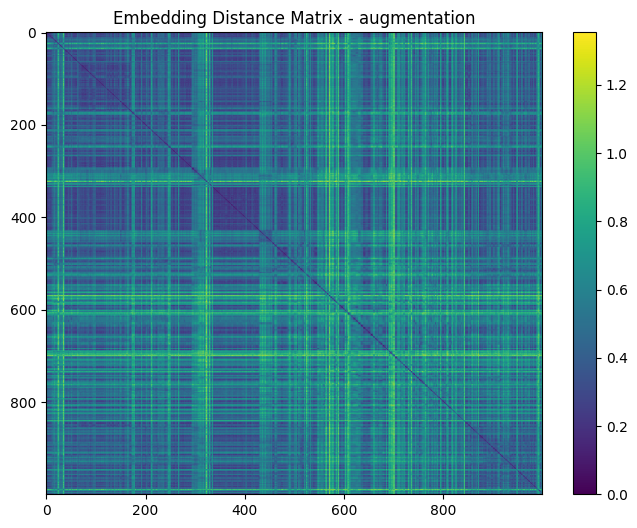

In [13]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"
epoch_to_test = 50  
sample_index = 10   


checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()
embedding_layer = model.bert.embeddings.word_embeddings
# This is a nn.Embedding, whose "weight" is a matrix of size [vocab_size, hidden_dim]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()
print("Embedding matrix shape:", embedding_weights.shape)


dist_matrix_embedding = cdist(embedding_weights[0:1000,:], embedding_weights[0:1000,:], metric='cosine')
print("Embedding distance matrix shape:", dist_matrix_embedding.shape)


reordered = dist_matrix_embedding[idx, :][:, idx]


plt.figure(figsize=(8, 6))
line_positions = [546, 842]

# for pos in line_positions:
#     plt.axhline(pos, color='red', linestyle='--', linewidth=1)
#     plt.axvline(pos, color='red', linestyle='--', linewidth=1)

plt.imshow(reordered, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Embedding Distance Matrix - augmentation")
plt.show()


# U map

In [15]:
import umap

In [91]:
embedding_weights.shape

(11318, 256)

Embedding matrix shape: (11318, 256)


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



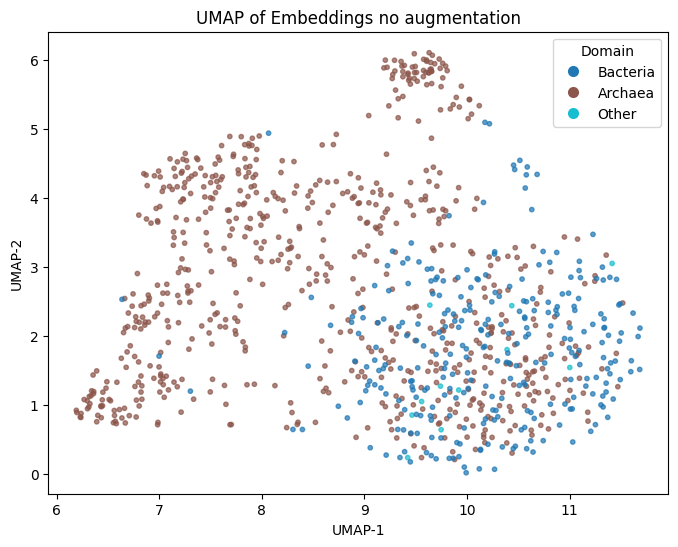

In [146]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_no_augmentation_50epochs"
epoch_to_test = 50  
sample_index = 10   


checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()
embedding_layer = model.bert.embeddings.word_embeddings
# This is a nn.Embedding, whose "weight" is a matrix of size [vocab_size, hidden_dim]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()
print("Embedding matrix shape:", embedding_weights.shape)

reducer = umap.UMAP(
    n_neighbors=15,      
    min_dist=0.1,        
    n_components=2,      
    random_state=123      
)


vocabulary_to_embed = 1000

embedding_2d = reducer.fit_transform(embedding_weights[0:vocabulary_to_embed])  # shape [N, 2]



vocab_size = len(token_dict)

# Make a list that is indexed by token_id => token_string.
id_to_token = [None] * vocab_size
for taxon_str, token_id in token_dict.items():
    id_to_token[token_id] = taxon_str
    


color_labels = np.zeros(vocab_size, dtype=int)  # integer array of labels

for i in range(vocab_size):
    taxon = id_to_token[i]
    if taxon.startswith("d__Bacteria"):
        color_labels[i] = 0  # e.g. color index 0 for Bacteria
    elif taxon.startswith("d__Archaea"):
        color_labels[i] = 1  # color index 1 for Archaea
    else:
        color_labels[i] = 2  # color index 2 for any other root domain
        



plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding_2d[:,0],
    embedding_2d[:,1],
    c=color_labels[0:vocabulary_to_embed],   # integer labels
    cmap='tab10',     # discrete colormap with 10 colors
    s=10,
    alpha=0.7
)

# Create a custom legend that draws exactly the same colors as the scatter
legend_labels = ["Bacteria", "Archaea", "Other"]
handles = []
for label_idx, label_name in enumerate(legend_labels):
    # Use the same normalization and colormap as the scatter
    color_val = scatter.cmap(scatter.norm(label_idx))
    handles.append(plt.Line2D(
        [0], [0],
        marker='o',
        markerfacecolor=color_val,
        markeredgecolor='none',
        markersize=8,
        linestyle='None',
        label=label_name
    ))

plt.legend(handles=handles, title="Domain")

plt.title("UMAP of Embeddings no augmentation")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

Embedding matrix shape: (11318, 256)


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



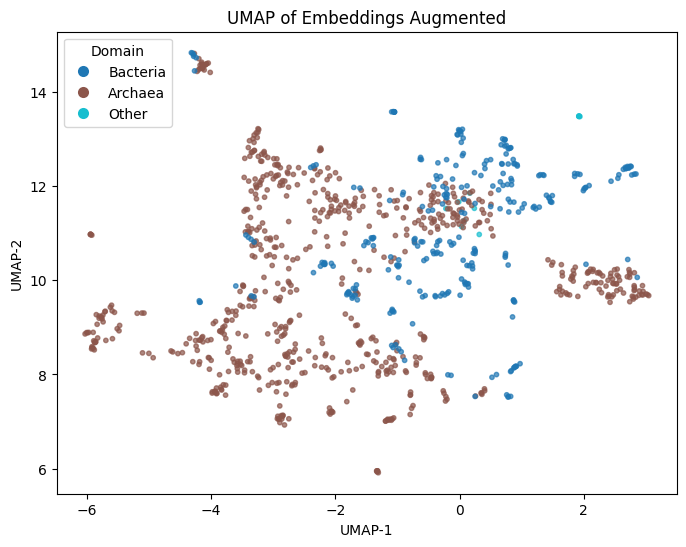

In [149]:
model_folder = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/my_taxonomy_model_augmentation_50epochs"
epoch_to_test = 50  
sample_index = 10   


checkpoint_name = f"checkpoint-epoch{epoch_to_test}"
checkpoint_path = os.path.join(model_folder, checkpoint_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForMaskedLM.from_pretrained(checkpoint_path)
model.to(device)
model.eval()
embedding_layer = model.bert.embeddings.word_embeddings
# This is a nn.Embedding, whose "weight" is a matrix of size [vocab_size, hidden_dim]
embedding_weights = embedding_layer.weight.detach().cpu().numpy()
print("Embedding matrix shape:", embedding_weights.shape)

reducer = umap.UMAP(
    n_neighbors=15,      
    min_dist=0.1,        
    n_components=2,      
    random_state=123      
)


vocabulary_to_embed = 1000 # 11318#1000


embedding_2d = reducer.fit_transform(embedding_weights[0:vocabulary_to_embed])  # shape [N, 2]



vocab_size = len(token_dict)

# Make a list that is indexed by token_id => token_string.
id_to_token = [None] * vocab_size
for taxon_str, token_id in token_dict.items():
    id_to_token[token_id] = taxon_str
    


color_labels = np.zeros(vocab_size, dtype=int)  # integer array of labels

for i in range(vocab_size):
    taxon = id_to_token[i]
    if taxon.startswith("d__Bacteria"):
        color_labels[i] = 0  # e.g. color index 0 for Bacteria
    elif taxon.startswith("d__Archaea"):
        color_labels[i] = 1  # color index 1 for Archaea
    else:
        color_labels[i] = 2  # color index 2 for any other root domain
        

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding_2d[:,0],
    embedding_2d[:,1],
    c=color_labels[0:vocabulary_to_embed],   # integer labels
    cmap='tab10',     # discrete colormap with 10 colors
    s=10,
    alpha=0.7
)

# Create a custom legend that draws exactly the same colors as the scatter
legend_labels = ["Bacteria", "Archaea", "Other"]
handles = []
for label_idx, label_name in enumerate(legend_labels):
    # Use the same normalization and colormap as the scatter
    color_val = scatter.cmap(scatter.norm(label_idx))
    handles.append(plt.Line2D(
        [0], [0],
        marker='o',
        markerfacecolor=color_val,
        markeredgecolor='none',
        markersize=8,
        linestyle='None',
        label=label_name
    ))

plt.legend(handles=handles, title="Domain")

plt.title("UMAP of Embeddings Augmented")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# interactive U maps

In [147]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10
from bokeh.io import output_file



In [150]:


label_map = {
    0: "Bacteria",
    1: "Archaea",
    2: "Other"
}
label_strings = [label_map[l] for l in color_labels]

sorted_taxa = sorted(token_dict.items(), key=lambda x: x[1])
subset_taxa_ids = sorted_taxa

# subset_taxa_ids is a list of (taxonomy_string, token_id) for the first 1000 tokens

df = pd.DataFrame({
    "umap_x": embedding_2d[:1000, 0],
    "umap_y": embedding_2d[:1000, 1],
    # We'll store the *string* taxonomy here for the hover tool
    "taxonomy": subset_taxa_ids[:1000],
    # We'll store the domain label as well
    "domain_label": label_strings[:1000]
})

source = ColumnDataSource(df)

factors = ["Bacteria", "Archaea", "Other"]
# pastel palette from Bokeh

p = figure(
    title="Augmented Umap of embeddings",
    width=1200,
    height=1000,
    tools="pan,wheel_zoom,box_zoom,reset"
)

# Use factor_cmap with the pastel palette
p.circle(
    x="umap_x",
    y="umap_y",
    source=source,
    size=6,
    alpha=1,
    color=factor_cmap("domain_label", palette=Category10[3], factors=["Bacteria", "Archaea", "Other"])
)

hover = HoverTool(tooltips=[("Taxonomy", "@taxonomy")])
p.add_tools(hover)
output_file("Augmented_plot.html")
save(p)

#show(p)


'/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/MetaFormer/Augmented_plot.html'

# print U-map and tree

In [132]:
special_tokens = {"<pad>", "<mask>", "<cls>", "<eos>"}

def get_parent_taxon(taxon_string):
    # For normal taxonomies, parse ranks
    # But for special tokens, return None so there's no parent
    if taxon_string in special_tokens:
        return None

    ranks = taxon_string.split(';')
    if len(ranks) > 1:
        return ';'.join(ranks[:-1])
    else:
        return None

In [133]:
sorted_taxa = sorted(token_dict.items(), key=lambda x: x[1])
# sorted_taxa is a list of (taxonomy_string, token_id) pairs in ascending order of token_id

subset_taxa_ids = sorted_taxa[:1000]
subset_taxa = [t[0] for t in subset_taxa_ids]  # list of taxonomy strings
subset_ids  = [t[1] for t in subset_taxa_ids]  # list of token_ids

# C) Subset embeddings
subset_embeddings = embedding_weights[subset_ids, :]  # shape: [1000, d]

In [134]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=123
)
embedding_2d = reducer.fit_transform(subset_embeddings[:1000])  # shape [1000, 2]

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [135]:
len(id_to_subset_index), embedding_2d.shape

(1000, (1000, 2))

In [136]:
# Map subset_ids[i] -> i (the index in the subset)
id_to_subset_index = {tid: i for i, tid in enumerate(subset_ids)}

lines_x = []
lines_y = []

# For each item in the subset
for i, taxon_str in enumerate(subset_taxa):
    child_id = subset_ids[i]
    parent_str = get_parent_taxon(taxon_str)
    if parent_str and parent_str in token_dict:
        parent_id = token_dict[parent_str]
        # Check if the parent is also in our first-1000 subset
        if parent_id in id_to_subset_index:
            parent_idx = id_to_subset_index[parent_id]
            # Coordinates in UMAP space
            x_child, y_child = embedding_2d[i]
            x_parent, y_parent = embedding_2d[parent_idx]

            lines_x.append([x_child, x_parent])
            lines_y.append([y_child, y_parent])


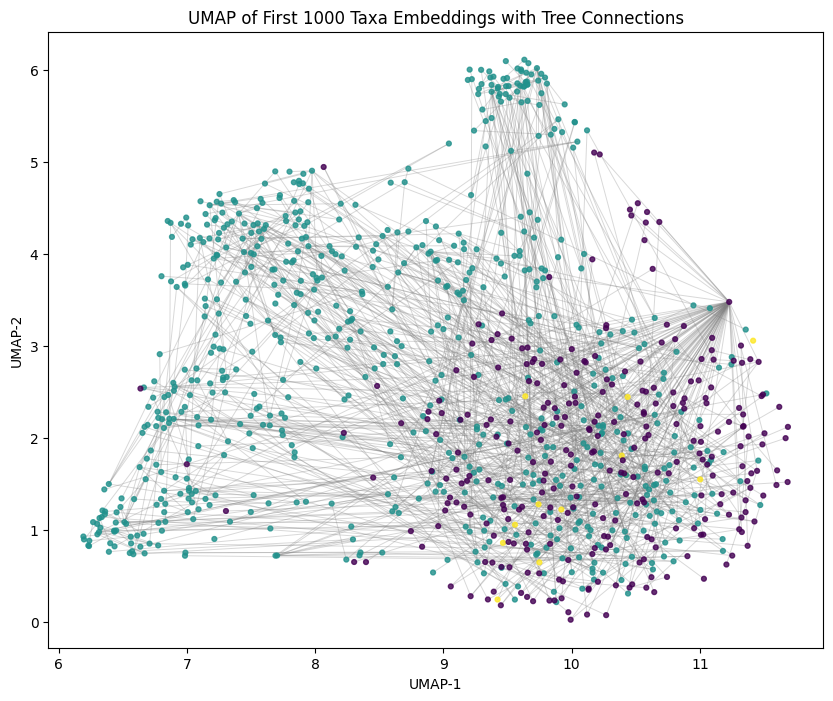

In [137]:

plt.figure(figsize=(10, 8))

# A) Draw lines first
for sx, sy in zip(lines_x, lines_y):
    plt.plot(sx, sy, color='gray', alpha=0.3, linewidth=0.7, zorder=1)

# B) Draw the scatter
plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=color_labels[0:1000],
    s=12,
    alpha=0.8,
    zorder=2
)

plt.title("UMAP of First 1000 Taxa Embeddings with Tree Connections")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

In [47]:
special_tokens = {"<pad>", "<mask>", "<cls>", "<eos>"}

def get_parent_taxon(taxon_string):
    # For normal taxonomies, parse ranks
    # But for special tokens, return None so there's no parent
    if taxon_string in special_tokens:
        return None

    ranks = taxon_string.split(';')
    if len(ranks) > 1:
        return ';'.join(ranks[:-1])
    else:
        return None

In [48]:
rank_level = {
    "d__": 0,  # domain
    "p__": 1,  # phylum
    "c__": 2,  # class
    "o__": 3,  # order
    "f__": 4,  # family
    "g__": 5,  # genus
    "s__": 6   # species
}
def compute_alpha_for_ranks(child_rank, parent_rank, base_alpha=0.8):
    """
    Example: the further the difference in rank, the lower the alpha.
    Or pick any function you want.
    """
    if child_rank not in rank_level or parent_rank not in rank_level:
        return 0.2  # default if ranks are unknown

    diff = abs(rank_level[child_rank] - rank_level[parent_rank])
    # Simple linear approach: alpha = base_alpha - 0.1 * diff
    # so if diff=1 => alpha = 0.7, diff=2 => alpha=0.6, etc.
    alpha_val = base_alpha - 0.1 * diff
    return max(alpha_val, 0.05)  # never go below 0.05


In [49]:
lines_x = []
lines_y = []
alphas = []

for i, child_taxon in enumerate(subset_taxa):
    child_id = subset_ids[i]
    parent_str = get_parent_taxon(child_taxon)
    if parent_str and parent_str in token_dict:
        parent_id = token_dict[parent_str]
        if parent_id in id_to_subset_index:
            parent_idx = id_to_subset_index[parent_id]
            x_child, y_child = embedding_2d[i]
            x_parent, y_parent = embedding_2d[parent_idx]

            # Compute alpha based on rank difference
            child_rank = get_last_rank(child_taxon)
            parent_rank = get_last_rank(parent_str)
            alpha_val = compute_alpha_for_ranks(child_rank, parent_rank)

            lines_x.append([x_child, x_parent])
            lines_y.append([y_child, y_parent])
            alphas.append(alpha_val)


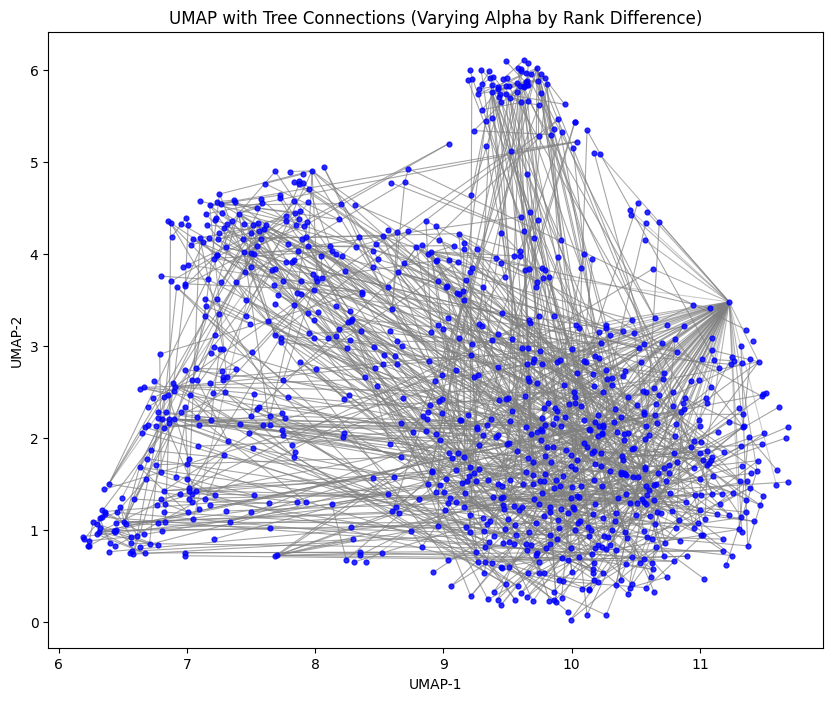

In [50]:
plt.figure(figsize=(10, 8))

for (sx, sy, a) in zip(lines_x, lines_y, alphas):
    plt.plot(sx, sy, color='gray', alpha=a, linewidth=0.8, zorder=1)

plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    s=12,
    c='blue',
    alpha=0.8,
    zorder=2
)

plt.title("UMAP with Tree Connections (Varying Alpha by Rank Difference)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

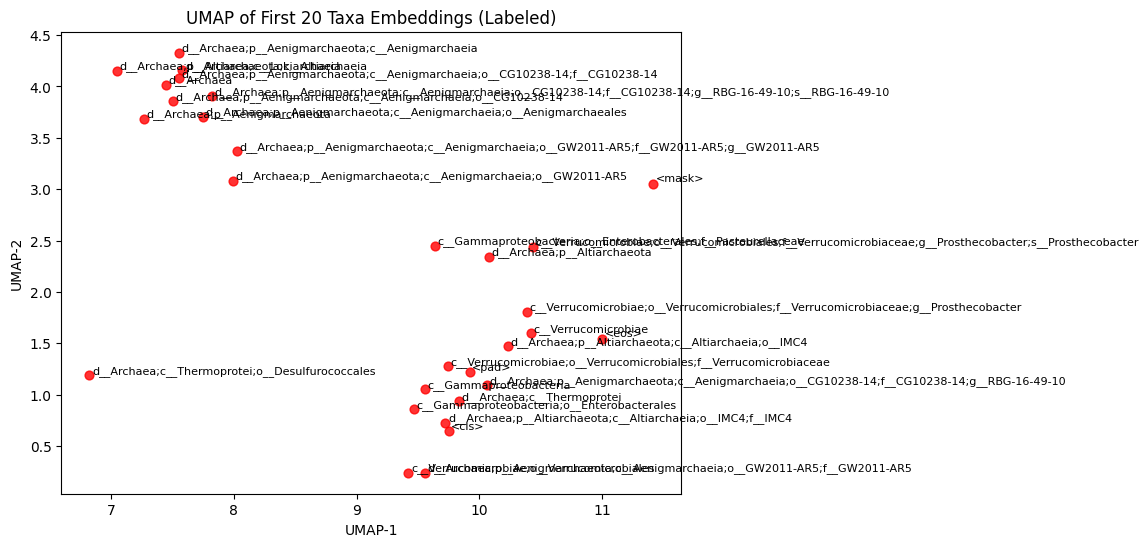

In [53]:

num_to_plot = 30
first_20_taxa = subset_taxa[:num_to_plot]
first_20_coords = embedding_2d[:num_to_plot]

plt.figure(figsize=(8, 6))

# Plot those 20 points in a scatter
plt.scatter(
    first_20_coords[:, 0],
    first_20_coords[:, 1],
    s=40,
    c='red',
    alpha=0.8
)

# Annotate each point with its taxonomy string
for i, taxon_str in enumerate(first_20_taxa):
    x, y = first_20_coords[i]
    # Adjust the text position slightly so it doesn't overlap the marker
    plt.text(
        x + 0.02, 
        y + 0.02, 
        taxon_str,
        fontsize=8
    )

plt.title("UMAP of First 20 Taxa Embeddings (Labeled)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()